In [34]:
import numpy as np
import math
import matplotlib.pyplot as plt
from jitcdde import jitcdde, y, t
from numpy import sin, cos
from tqdm import tqdm
from scipy.fftpack import fft, fftfreq
import symengine

# Physical constants
e_charge = 1.602e-19  # Coulombs
c = 3e8               # Speed of light (m/s)

# Laser parameters
alpha = 3.0           # Linewidth enhancement factor (dimensionless)
g = 1.2e4             # Differential gain coefficient (s^-1)
N_0 = 1.25e8          # Transparency carrier number (dimensionless)
s = 5e-7              # Saturation coefficient (dimensionless)s
gamma = 4.96e11       # Photon decay rate (s^-1)
gamma_e = 6.51e8      # Carrier decay rate (s^-1)
wavelength = 655e-9   # Laser wavelength (655 nm)

# Calculate the frequency (Hz) and angular frequency (rad/s)
frequency = c / wavelength  # f = c / λ

# Define Solitary Angular Freqeuncy and Average Angular Freqency
omega_1 = 2 * np.pi * frequency  # Laser 1 angular frequency (in rad/s) (Using 655nm wavelength)
omega_2 = 2 * np.pi * frequency  # Laser 2 angular frequency (in rad/s) (Using 655nm wavelength)

# Delta_omega = 0 * 2 * np.pi      # 0 GHz detuning in (rad/s) (Assume two lasers have the same freqeuncies: f_1=f_2)
# omega_2 = omega_1 + Delta_omega  # Laser 2 angular frequency
Omega = (omega_1 + omega_2) / 2  # Average (reference) angualr freqeuncy of two lasers
Delta_omega_1 = omega_1 - Omega  # Laser 1: 0 Detuning from reference angular frequnecy
Delta_omega_2 = omega_2 - Omega  # Laser 2: 0 Detuning from reference angular frequnecy

# Coupling parameters
kappa_values = [0.0]  # Varies coupling strength from 0 to 30ns^-1
tau_12 = tau_21 = 3.65e-9                # Dealy time (s)
phi_12 = phi_21 = 0.0                    # Propagation phase (rad). Assume no phase shift

# Injection currents
I_th = 17.35e-3    # Threshold current (= 17.35mA) 
I_1 = I_th + 1e-3  # Threhlod current of Laser 1 (A) = threshold current + 30mA = 47.35mA
I_2 = I_th + 1e-3  # Threhlod current of Laser 2 (A) = threshold current + 30mA = 47.35mA



# Time parameters
t_start = 0.0
t_end = 50e-9  # Total simulation time in seconds (50ns)
dt = 1e-9     # Time step in seconds (1ns)

# Define the log function and callback
log_func = symengine.Function("log_func")
def log_callback(y,value):
    print(f"[INFO] value: {value}")
    return value



cross_corr_values = []
# phase_sync_indices = []

for kappa in tqdm(kappa_values):
    # Define the system
    def system():
        # State variables
        E_R1 = y(0) # Real part of electric field of Laser 1
        E_I1 = y(1) # Imaginary part of electric field of Laser 1
        N_1 = y(2)  # Carrier density of Laser 1
        E_R2 = y(3) # Real part of electric field of Laser 2
        E_I2 = y(4) # Imaginary part of electric field of Laser 2
        N_2 = y(5)  # Carrier density of Laser 2

        # print(f"E_R1: {E_R1}, E_I1: {E_I1}, N_1: {N_1}, E_R2: {E_R2}, E_I2: {E_I2}, N_2: {N_2}")
        # E_I1 = log_func(E_I1)


        # Delayed variables
        E_R1_tau = y(0, t - tau_12) # Real part of the electric field of Laser 1 at a time t - tau due to the coupling delay (as seen by Laser 2)
        E_I1_tau = y(1, t - tau_12)
        E_R2_tau = y(3, t - tau_21) # Real part of the electric field of Laser 2 at a time t - tau due to the coupling delay (as seen by Laser 1)
        E_I2_tau = y(4, t - tau_21)
    

        # Intensities
        I1 = E_R1**2 + E_I1**2  # Intensity of Laser 1
        I2 = E_R2**2 + E_I2**2  # Intensity of Laser 2

        # Gain calculations
        G_1 = (g * (N_1 - N_0)) / (1 + s * I1)   # Net gain of Laser 1 
        G_2 = (g * (N_2 - N_0)) / (1 + s * I2)   # Net gain of Laser 2 

        I1 = log_func(I1)
        # G_1 = log_func(G_1)


        # Equations for Laser 1
        dE_R1_dt = -Delta_omega_1 * E_I1 + (1/2) * (G_1) * E_R1 - (alpha/2) * G_1 * E_I1 \
                   + kappa * (E_R2_tau * cos(phi_21) - E_I2_tau * sin(phi_21))

        dE_I1_dt = Delta_omega_1 * E_R1 + (1/2) * (G_1) * E_I1 + (alpha/2) * G_1 * E_R1 \
                   + kappa * (E_R2_tau * sin(phi_21) + E_I2_tau * cos(phi_21))

        dN_1_dt = (I_1 / e_charge) - gamma_e * N_1 - G_1 * I1

        # Equations for Laser 2
        dE_R2_dt = -Delta_omega_2 * E_I2 + (1/2) * (G_2) * E_R2 - (alpha/2) * G_2 * E_I2 \
                   + kappa * (E_R1_tau * cos(phi_12) - E_I1_tau * sin(phi_12))

        dE_I2_dt = Delta_omega_2 * E_R2 + (1/2) * (G_2) * E_I2 + (alpha/2) * G_2 * E_R2 \
                   + kappa * (E_R1_tau * sin(phi_12) + E_I1_tau * cos(phi_12))

        dN_2_dt = (I_2 / e_charge) - gamma_e * N_2 - G_2 * I2

        # print(f"dE_R1_dt: {dE_R1_dt}, dE_I1_dt: {dE_I1_dt}, dN_1_dt: {dN_1_dt}, dE_R2_dt: {dE_R2_dt}, dE_I2_dt: {dE_I2_dt}, dN_2_dt: {dN_2_dt}")

        return [dE_R1_dt, dE_I1_dt, dN_1_dt, dE_R2_dt, dE_I2_dt, dN_2_dt]

    # Initialize the solver
    # dde = jitcdde(system())
    # Initialize the solver with relaxed tolerances
    dde = jitcdde(system(), max_delay=max(tau_12, tau_21), callback_functions = [(log_func,log_callback,1)])

    # Set maximum delay
    dde.set_integration_parameters(rtol=1e-4, atol=1e-6)


    # Initial conditions
    E_R1_0 = 1e-6
    E_I1_0 = 0.0
    N_1_0 = N_0 + (I_1 / e_charge - gamma_e * N_0) / gamma_e
    E_R2_0 = 1e-6
    E_I2_0 = 0.0
    N_2_0 = N_0 + (I_2 / e_charge - gamma_e * N_0) / gamma_e

    dde.constant_past([E_R1_0, E_I1_0, N_1_0, E_R2_0, E_I2_0, N_2_0])

    # Start the simulation
    dde.step_on_discontinuities()

    # Time array
    times = np.arange(t_start, t_end, dt)
    outputs = []

    for time in times:
        # dde.integrate(time)
        # outputs.append(dde.y)
        state = dde.integrate(time)
        outputs.append(state)
        # print(state)

    outputs = np.array(outputs)
    E_R1_t = outputs[:, 0]
    E_I1_t = outputs[:, 1]
    N_1_t = outputs[:, 2]
    E_R2_t = outputs[:, 3]
    E_I2_t = outputs[:, 4]
    N_2_t = outputs[:, 5]

    # Compute intensities
    I1_t = E_R1_t**2 + E_I1_t**2
    I2_t = E_R2_t**2 + E_I2_t**2

    # Remove initial transients
    transient_cutoff = int(0.2 * len(I1_t))
    I1_t_trimmed = I1_t[transient_cutoff:]
    I2_t_trimmed = I2_t[transient_cutoff:]
    times_trimmed = times[transient_cutoff:]

    # Compute cross-correlation
    corr = np.correlate(I1_t_trimmed - np.mean(I1_t_trimmed), I2_t_trimmed - np.mean(I2_t_trimmed), mode='full')
    max_corr = np.max(corr)
    cross_corr_values.append(max_corr)

    # Phase synchronization analysis
    # phi_1_t = np.unwrap(np.arctan2(E_I1_t[transient_cutoff:], E_R1_t[transient_cutoff:]))
    # phi_2_t = np.unwrap(np.arctan2(E_I2_t[transient_cutoff:], E_R2_t[transient_cutoff:]))
    # delta_phi_t = phi_1_t - phi_2_t
    # R = np.abs(np.mean(np.exp(1j * delta_phi_t)))
    # phase_sync_indices.append(R)

# Plot cross-correlation vs coupling strength
plt.figure(figsize=(10, 6))
plt.plot(kappa_values, cross_corr_values, marker='o')
plt.xlabel('Coupling Strength κ (s$^{-1}$)')
plt.ylabel('Maximum Cross-Correlation')
plt.title('Cross-Correlation vs Coupling Strength')
plt.grid(True)
plt.show()

# plot laser 1 and laser 2 in subplots
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(times_trimmed, I1_t_trimmed, label='Laser 1')
plt.xlabel('Time (s)')
plt.ylabel('Intensity (W/m^2)')
plt.title('Laser Intensity vs Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(times_trimmed, I2_t_trimmed, label='Laser 2')
plt.xlabel('Time (s)')
plt.ylabel('Intensity (W/m^2)')
plt.legend()
plt.grid(True)
plt.show()


# Plot phase synchronization index vs coupling strength
# plt.figure(figsize=(10, 6))
# plt.plot(kappa_values, phase_sync_indices, marker='o')
# plt.xlabel('Coupling Strength κ (s$^{-1}$)')
# plt.ylabel('Phase Synchronization Index R')
# plt.title('Phase Synchronization vs Coupling Strength')
# plt.grid(True)
# plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


/opt/anaconda3/lib/python3.7/site-packages/jitcdde/_jitcdde.py:525: UserWarning: Differential equation does not include a delay term.
  warn("Differential equation does not include a delay term.")
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/distutils/core.py", line 148, in setup
    dist.run_commands()
  File "/opt/anaconda3/lib/python3.7/distutils/dist.py", line 966, in run_commands
    self.run_command(cmd)
  File "/opt/anaconda3/lib/python3.7/distutils/dist.py", line 985, in run_command
    cmd_obj.run()
  File "/opt/anaconda3/lib/python3.7/site-packages/setuptools/command/build_ext.py", line 87, in run
    _build_ext.run(self)
  File "/opt/anaconda3/lib/python3.7/site-packages/Cython/Distutils/old_build_ext.py", line 186, in run
    _build_ext.build_ext.run(self)
  File "/opt/anaconda3/lib/python3.7/distutils/command/build_ext.py", line 340, in run
    self.build_extensions()
  File "/opt/anaconda3/lib/python3.7/site-packages/jitcxde_common/_jitcxde.py", line 304, in build_extensions
    build_ext.build_extensions(self)
  File "/opt/anaconda3/lib/python3.7/site-packages/Cython/Distutils/old_build_ext.py", line 195, in build_extensions
    _build_e

SystemExit: interrupted

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
from jitcdde import jitcdde, y, t
from numpy import sin, cos
from tqdm import tqdm
from scipy.fftpack import fft, fftfreq
import symengine

# Physical constants
e_charge = 1.602e-19  # Coulombs
c = 3e8               # Speed of light (m/s)

# Laser parameters
alpha = 3.0           # Linewidth enhancement factor (dimensionless)
g = 1.2e4             # Differential gain coefficient (s^-1)
N_0 = 1.25e8          # Transparency carrier number (dimensionless)
s = 5e-7              # Saturation coefficient (dimensionless)s
gamma = 4.96e11       # Photon decay rate (s^-1)
gamma_e = 6.51e8      # Carrier decay rate (s^-1)
wavelength = 655e-9   # Laser wavelength (655 nm)

# Calculate the frequency (Hz) and angular frequency (rad/s)
frequency = c / wavelength  # f = c / λ

# Define Solitary Angular Freqeuncy and Average Angular Freqency
omega_1 = 2 * np.pi * frequency  # Laser 1 angular frequency (in rad/s) (Using 655nm wavelength)
omega_2 = 2 * np.pi * frequency  # Laser 2 angular frequency (in rad/s) (Using 655nm wavelength)

# Injection currents
I_th = 17.35e-3    # Threshold current (= 17.35mA) 
I_1 = I_th + 1e-3  # Threhlod current of Laser 1 (A) (Assume high pump current)
I_2 = I_th + 1e-3  # Threhlod current of Laser 2 (A) 



# Time parameters
t_start = 0.0
t_end = 5e-9    # Total simulation time in seconds (5ns)
dt = 0.1e-9     # Time step in seconds (0.1ns)

# Define the log function and callback
log_func = symengine.Function("log_func")
def log_callback(y,value):
    print(f"[INFO] value: {value}")
    return value



cross_corr_values = []
# phase_sync_indices = []

# for kappa in tqdm(kappa_values):
for i in range(1):
    # Define the system
    def system():
        # State variables
        E_R1 = y(0) # Real part of electric field of Laser 1
        E_I1 = y(1) # Imaginary part of electric field of Laser 1
        N_1 = y(2)  # Carrier density of Laser 1
        E_R2 = y(3) # Real part of electric field of Laser 2
        E_I2 = y(4) # Imaginary part of electric field of Laser 2
        N_2 = y(5)  # Carrier density of Laser 2

        # print(f"E_R1: {E_R1}, E_I1: {E_I1}, N_1: {N_1}, E_R2: {E_R2}, E_I2: {E_I2}, N_2: {N_2}")
        # E_I1 = log_func(E_I1)

        # Intensities
        I1 = E_R1**2 + E_I1**2  # Intensity of Laser 1
        I2 = E_R2**2 + E_I2**2  # Intensity of Laser 2

        # Gain calculations
        G_1 = 1*(g * (N_1 - N_0)) / (1 + s * I1)   # Net gain of Laser 1 
        G_2 = 1*(g * (N_2 - N_0)) / (1 + s * I2)   # Net gain of Laser 2 

        I1 = log_func(I1)
        # G_1 = log_func(G_1)


        # Equations for Laser 1
        dE_R1_dt = 1/2 * (G_1 - gamma) * E_R1 - (alpha/2) * (G_1 - gamma) * E_I1 
        dE_I1_dt = 1/2 * (G_1 - gamma) * E_I1 - (alpha/2) * (G_1 - gamma) * E_R1
        dN_1_dt = (I_1 / e_charge) - gamma_e * N_1 - G_1 * I1

        # Equations for Laser 2
        dE_R2_dt = 1/2 * (G_2 - gamma) * E_R2 - (alpha/2) * (G_2 - gamma) * E_I2
        dE_I2_dt = 1/2 * (G_2 - gamma) * E_I2 - (alpha/2) * (G_2 - gamma) * E_R2
        dN_2_dt = (I_2 / e_charge) - gamma_e * N_2 - G_2 * I2
        
        # print(f"dE_R1_dt: {dE_R1_dt}, dE_I1_dt: {dE_I1_dt}, dN_1_dt: {dN_1_dt}, dE_R2_dt: {dE_R2_dt}, dE_I2_dt: {dE_I2_dt}, dN_2_dt: {dN_2_dt}")

        return [dE_R1_dt, dE_I1_dt, dN_1_dt, dE_R2_dt, dE_I2_dt, dN_2_dt]

    # Initialize the solver
    # dde = jitcdde(system())
    # Initialize the solver with relaxed tolerances
    tau_12 = 0
    tau_21 = 0
    dde = jitcdde(system(), max_delay=max(tau_12, tau_21), callback_functions = [(log_func,log_callback,1)])

    # Set maximum delay
    dde.set_integration_parameters(rtol=1e-4, atol=1e-6)


    # Initial conditions
    E_R1_0 = 1e-6
    E_I1_0 = 0.0
    N_1_0 = N_0 + (I_1 / e_charge - gamma_e * N_0 )
    E_R2_0 = 1e-6
    E_I2_0 = 0.0
    N_2_0 = N_0 + (I_2 / e_charge - gamma_e * N_0) 

    dde.constant_past([E_R1_0, E_I1_0, N_1_0, E_R2_0, E_I2_0, N_2_0])

    # Start the simulation
    dde.step_on_discontinuities()

    # Time array
    times = np.arange(t_start, t_end, dt)
    outputs = []

    for time in times:
        # dde.integrate(time)
        # outputs.append(dde.y)
        state = dde.integrate(time)
        outputs.append(state)
        # print(state)

    outputs = np.array(outputs)
    E_R1_t = outputs[:, 0]
    E_I1_t = outputs[:, 1]
    N_1_t = outputs[:, 2]
    E_R2_t = outputs[:, 3]
    E_I2_t = outputs[:, 4]
    N_2_t = outputs[:, 5]

    # Compute intensities
    I1_t = E_R1_t**2 + E_I1_t**2
    I2_t = E_R2_t**2 + E_I2_t**2

    # Remove initial transients
    transient_cutoff = int(0.2 * len(I1_t))
    I1_t_trimmed = I1_t[transient_cutoff:]
    I2_t_trimmed = I2_t[transient_cutoff:]
    times_trimmed = times[transient_cutoff:]

    # Compute cross-correlation
    corr = np.correlate(I1_t_trimmed - np.mean(I1_t_trimmed), I2_t_trimmed - np.mean(I2_t_trimmed), mode='full')
    max_corr = np.max(corr)
    cross_corr_values.append(max_corr)


# Plot cross-correlation vs coupling strength
plt.figure(figsize=(10, 6))
plt.plot(kappa_values, cross_corr_values, marker='o')
plt.xlabel('Coupling Strength κ (s$^{-1}$)')
plt.ylabel('Maximum Cross-Correlation')
plt.title('Cross-Correlation vs Coupling Strength')
plt.grid(True)
plt.show()

# plot laser 1 and laser 2 in subplots
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(times_trimmed, I1_t_trimmed, label='Laser 1')
plt.xlabel('Time (s)')
plt.ylabel('Intensity (W/m^2)')
plt.title('Laser Intensity vs Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(times_trimmed, I2_t_trimmed, label='Laser 2')
plt.xlabel('Time (s)')
plt.ylabel('Intensity (W/m^2)')
plt.legend()
plt.grid(True)
plt.show()



Generating, compiling, and loading C code.


/opt/anaconda3/lib/python3.7/site-packages/jitcdde/_jitcdde.py:525: UserWarning: Differential equation does not include a delay term.
  warn("Differential equation does not include a delay term.")


[INFO] value: 1e-12
[INFO] value: 9.901833840162688e+28
[INFO] value: 4.6589174321999584e+52
[INFO] value: 8.656608280594169e+75
[INFO] value: 3.960733536065075e+27
[INFO] value: 7.45458252052199e+49
[INFO] value: 5.540463140988086e+71
[INFO] value: 1.5842934144260306e+26
[INFO] value: 1.1929849224020593e+47
[INFO] value: 3.5466447500569594e+67
[INFO] value: 6.337173657704122e+24
[INFO] value: 1.910790265467073e+44
[INFO] value: 2.2722480845877785e+63
[INFO] value: 2.5348694630816492e+23
[INFO] value: 3.0734050086586686e+41
[INFO] value: 1.4619163104568296e+59
[INFO] value: 1.01394778523266e+22
[INFO] value: 5.047591342563823e+38
[INFO] value: 9.603883713238038e+54
[INFO] value: 4.055791140930639e+20
[INFO] value: 9.158035189447056e+35
[INFO] value: 6.9698750877891845e+50
[INFO] value: 1.6223164563722566e+19
[INFO] value: 2.4936888173477136e+33
[INFO] value: 7.591452574971532e+46
[INFO] value: 6.48926582548903e+17
[INFO] value: 1.8717276532396886e+31
[INFO] value: 2.2792135084192676e+4

UnsuccessfulIntegration: 
Could not integrate with the given tolerance parameters:

atol: 1.000000e-06
rtol: 1.000000e-04
min_step: 1.000000e-10

The most likely reasons for this are:
• The DDE is ill-posed or stiff.
• You used `integrate_blindly` and did not adjust the maximum step or you used `adjust_diff` and did not pay attention to the extrema.

In [7]:
# In this example, we implement the sunflower equation. First, we do it regularly, then we repeat the process using callbacks.

from jitcdde import jitcdde, y, t
import numpy as np

a = 4.8
b = 0.186
tau = 40

# Regular implementation
# ----------------------
# To implement the sine function, we use SymEngine’s sine. This is a symbolic function that gets translated to a C implementation of the sine function under the hood.

import symengine
f = [
		y(1),
		-a/tau*y(1) - b/tau*symengine.sin(y(0,t-tau))
	]
DDE_regular = jitcdde(f)

# With Callbacks
# --------------
# Now, let’s assume for example’s sake that we did not have a sine function for straightforward use like above (i.e., a symbolic SymEngine function that gets translated to a C implementation). Instead we have to use the one from the Python’s Math library.

my_sine = symengine.Function("my_sine")
f_with_callback = [
		y(1),
		-a/tau*y(1) - b/tau*my_sine(y(0,t-tau))
	]

# We need to introduce a wrapper to match the required signature for callbacks. We also add a `print` statement to see when the callback was called. Except for the latter, we do not use the first argument, which is a vector containing the entire present state of the system:

import math
def my_sine_callback(y,arg):
	print(f"my_sine called with arguments {y} and {arg}")
	return math.sin(arg)

DDE_callback = jitcdde(
		f_with_callback,
		callback_functions = [(my_sine,my_sine_callback,1)],
	)

# Integration
# -----------
# Initialise and address initial discontinuities for both implementations:
DDE_regular.constant_past( [1.0,0.0], time=0.0 )
DDE_regular.adjust_diff()
DDE_callback.constant_past( [1.0,0.0], time=0.0 )
DDE_callback.adjust_diff()
assert DDE_regular.t == DDE_callback.t

# Integrate side by side and compare:
times = DDE_regular.t + np.arange(10,100,10)
for time in times:
	assert DDE_regular.integrate(time)[0] == DDE_callback.integrate(time)[0]

Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
my_sine called with arguments [1. 0.] and 1.0
my_sine called with arguments [ 1.         -0.00195642] and 1.0
my_sine called with arguments [ 0.99853268 -0.00275855] and 1.0
my_sine called with arguments [ 0.99812184 -0.00368746] and 1.0
my_sine called with arguments [ 1.00000000e+00 -5.80283806e-04] and 1.0
my_sine called with arguments [ 9.99870914e-01 -8.54935357e-04] and 1.0
my_sine called with arguments [ 0.99982993 -0.00114016] and 1.0
my_sine called with arguments [ 1.00000000e+00 -3.81357762e-04] and 1.0
my_sine called with arguments [ 9.99944248e-01 -5.65346343e-04] and 1.0
my_sine called with arguments [ 9.99926243e-01 -7.53864677e-04] and 1.0
my_sine called with arguments [ 1.00000000e+00 -3.31333555e-04] and 1.0
my_sine called with arguments [ 9.99957915e-01 -4.91950101e-04] and 1.0
my_sine called with arguments [ 

AssertionError: 

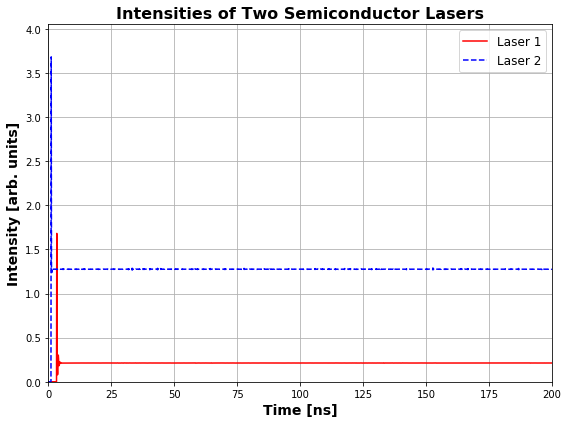

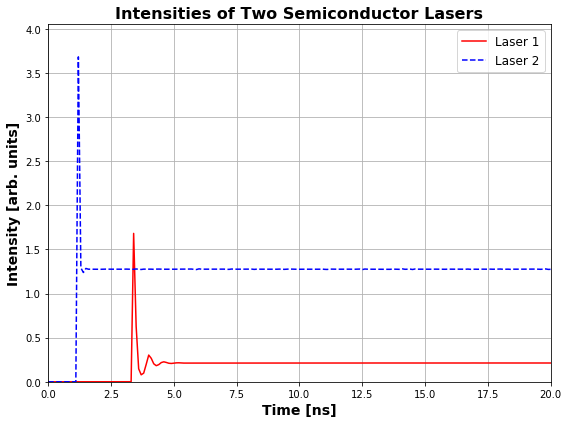

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
e_charge = 1.602e-19  # Coulombs
c = 3e8  # Speed of light (m/s)

# Laser parameters
alpha = 3.0  # Linewidth enhancement factor
g = 1.2e4  # Differential gain coefficient (s^-1)
N_0 = 1.25e8  # Transparency carrier number (dimensionless)
s = 5e-7  # Saturation coefficient (dimensionless)
gamma = 4.96e11  # Photon decay rate (s^-1)
gamma_e = 6.51e8  # Carrier decay rate (s^-1)
wavelength = 655e-9  # Laser wavelength (m)

# Injection currents
I_th = 17.35e-3  # Threshold current (A)
I_1 = 1.1*I_th  # Laser 1 injection current (A)
I_2 = 1.6*I_th  # Laser 2 injection current (A)

# Define rate equations
def laser_rate_equations(t, y, I):
    X, Y, N = y
    E = X + 1j * Y
    G = g * (N - N_0) / (1 + s * np.abs(E)**2) 
    
    dX_dt = 0.5 * (G-gamma) * (X - alpha * Y)
    dY_dt = 0.5 * (G-gamma) * (Y + alpha * X)
    dN_dt = (I / e_charge) - gamma_e * N - G * np.abs(E)**2
    
    return [dX_dt, dY_dt, dN_dt]

# Initial conditions and time span
initial_conditions = [0.1, 0.1, 1e8]   # Initial conditions for X, Y, and N
time_span = (0, 2e-7)                  # Time span for the simulation(s) 2e-7s = 200ns
time_eval = np.linspace(0, 2e-7, 2000) # Time points to evaluate the solution (2000 points between 0 and 200ns)

# Solve ODEs for Laser 1 and Laser 2
solution_laser_1 = solve_ivp(laser_rate_equations, time_span, initial_conditions, t_eval=time_eval, args=(I_1,))
solution_laser_2 = solve_ivp(laser_rate_equations, time_span, initial_conditions, t_eval=time_eval, args=(I_2,))

# Extract intensity from the solution (I = |E|^2) and convert to W/m^2
conversion_factor = 1e-3  # Arbitrary conversion factor to convert to W/m^2
intensity_laser_1 = (solution_laser_1.y[0]**2 + solution_laser_1.y[1]**2) * conversion_factor / 100
intensity_laser_2 = (solution_laser_2.y[0]**2 + solution_laser_2.y[1]**2) * conversion_factor / 100

# Plot both intensities in one graph
plt.figure(figsize=(8, 6))
plt.plot(solution_laser_1.t * 1e9, intensity_laser_1, label="Laser 1", color='r', linestyle='-')
plt.plot(solution_laser_2.t * 1e9, intensity_laser_2, label="Laser 2", color='b', linestyle='--')
plt.xlabel('Time [ns]', fontsize=14, fontweight='bold')
plt.ylabel('Intensity [arb. units]', fontsize=14, fontweight='bold')
plt.xlim(0, 200)
plt.ylim(0, max(np.max(intensity_laser_1), np.max(intensity_laser_2)) * 1.1)
plt.title('Intensities of Two Semiconductor Lasers', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()

#subplots
plt.figure(figsize=(8, 6))
plt.plot(solution_laser_1.t * 1e9, intensity_laser_1, label="Laser 1", color='r', linestyle='-')
plt.plot(solution_laser_2.t * 1e9, intensity_laser_2, label="Laser 2", color='b', linestyle='--')
plt.xlabel('Time [ns]', fontsize=14, fontweight='bold')
plt.ylabel('Intensity [arb. units]', fontsize=14, fontweight='bold')
plt.xlim(0, 20)
plt.ylim(0, max(np.max(intensity_laser_1), np.max(intensity_laser_2)) * 1.1)
plt.title('Intensities of Two Semiconductor Lasers', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

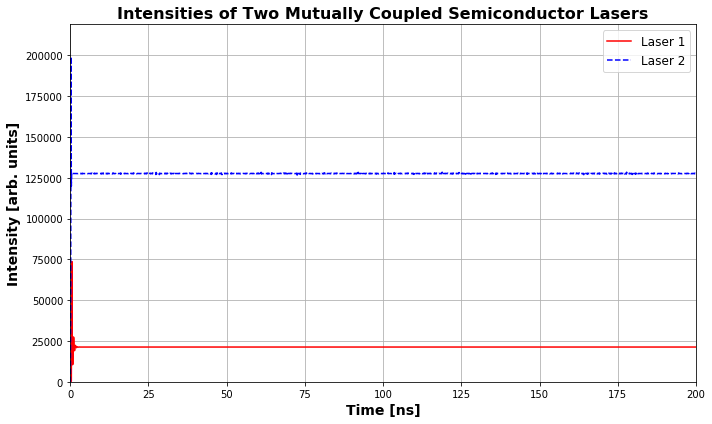

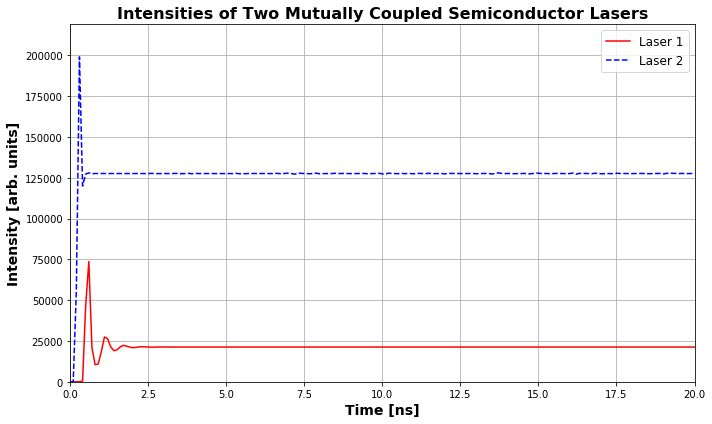

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
e_charge = 1.602e-19  # Coulombs
c = 3e8                # Speed of light (m/s)

# Laser parameters
alpha = 3.0            # Linewidth enhancement factor
g = 1.2e4              # Differential gain coefficient (s^-1)
N0 = 1.25e8            # Transparency carrier number (dimensionless)
s = 5e-7               # Saturation coefficient (dimensionless)
gamma = 4.96e11        # Photon decay rate (s^-1)
gamma_e = 6.51e8       # Carrier decay rate (s^-1)
wavelength = 655e-9    # Laser wavelength (m)

# Injection currents
I_th = 17.35e-3        # Threshold current (A)
I_1 = 1.1*I_th       # Laser 1 injection current (A)
I_2 = 1.6*I_th       # Laser 2 injection current (A)

# Coupling strengths
kappa_12 = 1e7         # Coupling strength from Laser 2 to Laser 1 (s^-1) # 1e7 = 10ns^-1
kappa_21 = 1e7         # Coupling strength from Laser 1 to Laser 2 (s^-1) # 1e7 = 10ns^-1

# Define rate equations for coupled lasers
def coupled_laser_rate_equations(t, y, params):
    """
    Computes the derivatives for two mutually coupled semiconductor lasers.

    Parameters:
    - t: Time variable (not used as equations are autonomous)
    - y: State vector [X1, Y1, N1, X2, Y2, N2]
    - params: List of parameters
        [g, N0, s, gamma, gamma_e, alpha, kappa_12, kappa_21, I1, I2, e_charge]

    Returns:
    - dydt: Derivatives [dX1/dt, dY1/dt, dN1/dt, dX2/dt, dY2/dt, dN2/dt]
    """
    X1, Y1, N1, X2, Y2, N2 = y
    g, N0, s, gamma, gamma_e, alpha, kappa_12, kappa_21, I1, I2, e_charge = params

    # Calculate optical gain for both lasers
    G1 = (g * (N1 - N0)) / (1 + s * (X1**2 + Y1**2))
    G2 = (g * (N2 - N0)) / (1 + s * (X2**2 + Y2**2))

    # Electric field equations for Laser 1
    dX1_dt = 0.5 * (G1 - gamma) * (X1 - alpha * Y1) + kappa_12 * X2
    dY1_dt = 0.5 * (G1 - gamma) * (Y1 + alpha * X1) + kappa_12 * Y2

    # Electric field equations for Laser 2
    dX2_dt = 0.5 * (G2 - gamma) * (X2 - alpha * Y2) + kappa_21 * X1
    dY2_dt = 0.5 * (G2 - gamma) * (Y2 + alpha * X2) + kappa_21 * Y1

    # Carrier density equations for Laser 1
    dN1_dt = (I1 / e_charge) - gamma_e * N1 - G1 * (X1**2 + Y1**2)

    # Carrier density equations for Laser 2
    dN2_dt = (I2 / e_charge) - gamma_e * N2 - G2 * (X2**2 + Y2**2)

    return [dX1_dt, dY1_dt, dN1_dt, dX2_dt, dY2_dt, dN2_dt]

# Pack parameters into a list for easy passing
params = [g, N0, s, gamma, gamma_e, alpha, kappa_12, kappa_21, I_1, I_2, e_charge]

# Initial conditions: [X1, Y1, N1, X2, Y2, N2]
initial_conditions = [0.1, 0.1, N0 + gamma / g, 0.1, 0.1, N0 + gamma / g]

# Time span for the simulation: 0 to 200 ns
time_span = (0, 2e-7)                     # 2e-7 seconds = 200 ns
time_eval = np.linspace(0, 2e-7, 2000)    # 2000 points between 0 and 200 ns

# Solve the coupled ODEs
solution = solve_ivp(
    coupled_laser_rate_equations,
    time_span,
    initial_conditions,
    t_eval=time_eval,
    args=(params,),
    method='RK45'
)

# Extract solutions
X1 = solution.y[0]
Y1 = solution.y[1]
N1 = solution.y[2]
X2 = solution.y[3]
Y2 = solution.y[4]
N2 = solution.y[5]

# Calculate intensity for both lasers
intensity_laser_1 = X1**2 + Y1**2
intensity_laser_2 = X2**2 + Y2**2

# Plot both intensities in one graph
plt.figure(figsize=(10, 6))
plt.plot(solution.t * 1e9, intensity_laser_1, label="Laser 1", color='r', linestyle='-')
plt.plot(solution.t * 1e9, intensity_laser_2, label="Laser 2", color='b', linestyle='--')
plt.xlabel('Time [ns]', fontsize=14, fontweight='bold')
plt.ylabel('Intensity [arb. units]', fontsize=14, fontweight='bold')
plt.title('Intensities of Two Mutually Coupled Semiconductor Lasers', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.xlim(0, 200)  # Display full 200 ns simulation
plt.ylim(0, max(np.max(intensity_laser_1), np.max(intensity_laser_2)) * 1.1)
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 6))
plt.plot(solution.t * 1e9, intensity_laser_1, label="Laser 1", color='r', linestyle='-')
plt.plot(solution.t * 1e9, intensity_laser_2, label="Laser 2", color='b', linestyle='--')
plt.xlabel('Time [ns]', fontsize=14, fontweight='bold')
plt.ylabel('Intensity [arb. units]', fontsize=14, fontweight='bold')
plt.title('Intensities of Two Mutually Coupled Semiconductor Lasers', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.xlim(0, 20)  # Display partial 20 ns simulation
plt.ylim(0, max(np.max(intensity_laser_1), np.max(intensity_laser_2)) * 1.1)
plt.grid(True)
plt.tight_layout()

plt.show()


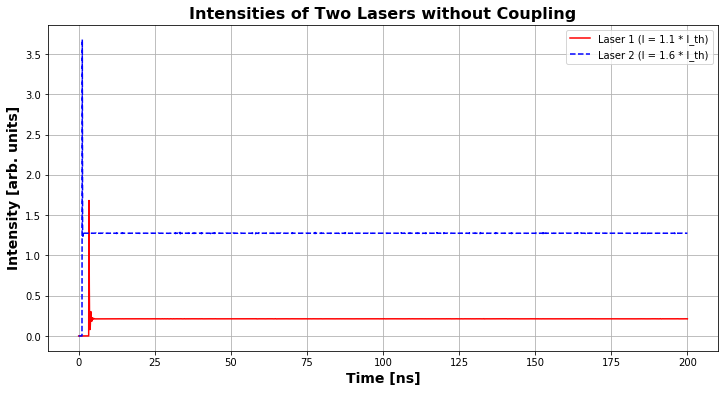

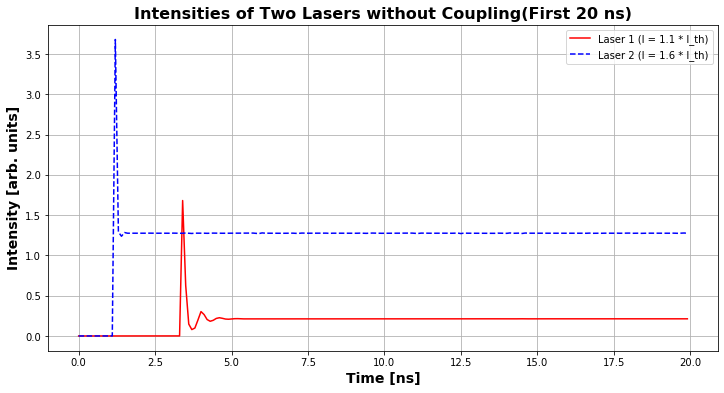

In [21]:
# Electical Field Intensity of Laser 1 and Laser 2 (without coupling)
# Differnt pump current for Laser 1 (1.1*I_th) and Laser 2 (1.6*I_th)

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
e_charge = 1.602e-19  # Coulombs
c = 3e8  # Speed of light (m/s)

# Laser parameters
alpha = 3.0  # Linewidth enhancement factor
g = 1.2e4  # Differential gain coefficient (s^-1)
N_0 = 1.25e8  # Transparency carrier number (dimensionless)
s = 5e-7  # Saturation coefficient (dimensionless)
gamma = 4.96e11  # Photon decay rate (s^-1)
gamma_e = 6.51e8  # Carrier decay rate (s^-1)
wavelength = 655e-9  # Laser wavelength (m)

# Injection currents
I_th = 17.35e-3  # Threshold current (A)
I_1 = 1.1 * I_th  # Laser 1 injection current (A)
I_2 = 1.6 * I_th  # Laser 2 injection current (A)

# Define rate equations
def laser_rate_equations(t, y, I):
    X, Y, N = y
    E = X + 1j * Y
    G = g * (N - N_0) / (1 + s * np.abs(E) ** 2)

    dX_dt = 0.5 * (G - gamma) * (X - alpha * Y)
    dY_dt = 0.5 * (G - gamma) * (Y + alpha * X)
    dN_dt = (I / e_charge) - gamma_e * N - G * np.abs(E) ** 2

    return [dX_dt, dY_dt, dN_dt]

# Initial conditions and time span
initial_conditions = [0.1, 0.1, 1e8]  # Initial conditions for X, Y, and N
time_span = (0, 2e-7)  # Time span for the simulation(s) 2e-7s = 200ns
time_eval = np.linspace(0, 2e-7, 2000)  # Time points to evaluate the solution (2000 points between 0 and 200ns)

# Solve ODEs for Laser 1 and Laser 2
solution_laser_1 = solve_ivp(laser_rate_equations, time_span, initial_conditions, t_eval=time_eval, args=(I_1,))
solution_laser_2 = solve_ivp(laser_rate_equations, time_span, initial_conditions, t_eval=time_eval, args=(I_2,))

# Extract intensity (|E|^2) for both lasers
intensity_laser_1 = solution_laser_1.y[0] ** 2 + solution_laser_1.y[1] ** 2
intensity_laser_2 = solution_laser_2.y[0] ** 2 + solution_laser_2.y[1] ** 2

# Convert time to nanoseconds
time_ns = solution_laser_1.t * 1e9

conversion_factor = 1e5

# Plot both intensities over the entire time interval
plt.figure(figsize=(12, 6))
plt.plot(time_ns, intensity_laser_1/conversion_factor, label="Laser 1 (I = 1.1 * I_th)", color='r')
plt.plot(time_ns, intensity_laser_2/conversion_factor, label="Laser 2 (I = 1.6 * I_th)", linestyle='--', color='b')
plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Intensities of Two Lasers without Coupling",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

plt.show()

# Plot both intensities for the first 20 ns
plt.figure(figsize=(12, 6))
plt.plot(time_ns[time_ns <= 20], intensity_laser_1[time_ns <= 20]/conversion_factor, label="Laser 1 (I = 1.1 * I_th)", color='r')
plt.plot(time_ns[time_ns <= 20], intensity_laser_2[time_ns <= 20]/conversion_factor, label="Laser 2 (I = 1.6 * I_th)", linestyle='--', color='b')
plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Intensities of Two Lasers without Coupling(First 20 ns)",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()
plt.show()


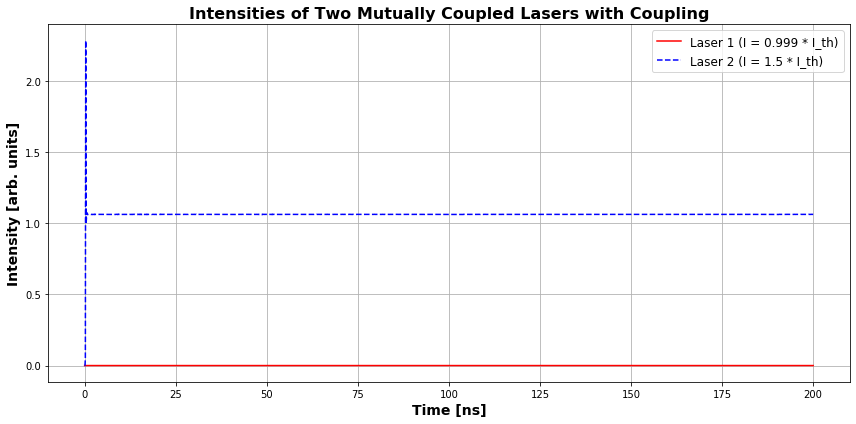

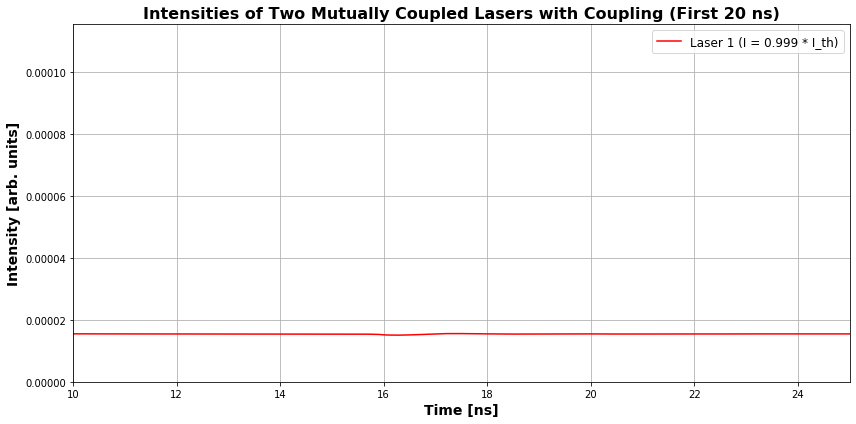

In [24]:
# Electrical Field Intensity of Laser 1 and Laser 2 (with coupling)
# Different pump current for Laser 1 (1.1*I_th) and Laser 2 (1.6*I_th)

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
e_charge = 1.602e-19  # Coulombs
c = 3e8  # Speed of light (m/s)

# Laser parameters
alpha = 3.0  # Linewidth enhancement factor
g = 1.2e4  # Differential gain coefficient (s^-1)
N_0 = 1.25e8  # Transparency carrier number (dimensionless)
s = 5e-7  # Saturation coefficient (dimensionless)
gamma = 4.96e11  # Photon decay rate (s^-1)
gamma_e = 6.51e8  # Carrier decay rate (s^-1)
wavelength = 655e-9  # Laser wavelength (m)

# Injection currents
I_th = 17.35e-3  # Threshold current (A)
I_1_factor = 0.999
I_1 = I_1_factor * I_th  # Laser 1 injection current (A) (Assume low pump current)
I_2_factor = 1.5
I_2 = I_2_factor * I_th  # Laser 2 injection current (A)

# Coupling strengths
kappa_12 = 1e7  # Coupling strength from Laser 2 to Laser 1 (s^-1) # 1e7 = 10ns^-1
kappa_21 = 1e7  # Coupling strength from Laser 1 to Laser 2 (s^-1) 

# Define rate equations for coupled lasers
def coupled_laser_rate_equations(t, y, params):
    """
    Computes the derivatives for two mutually coupled semiconductor lasers.

    Parameters:
    - t: Time variable (not used as equations are autonomous)
    - y: State vector [X1, Y1, N1, X2, Y2, N2]
    - params: List of parameters
        [g, N0, s, gamma, gamma_e, alpha, kappa_12, kappa_21, I1, I2, e_charge]

    Returns:
    - dydt: Derivatives [dX1/dt, dY1/dt, dN1/dt, dX2/dt, dY2/dt, dN2/dt]
    """
    X1, Y1, N1, X2, Y2, N2 = y
    g, N0, s, gamma, gamma_e, alpha, kappa_12, kappa_21, I1, I2, e_charge = params

    # Calculate optical gain for both lasers
    G1 = (g * (N1 - N0)) / (1 + s * (X1**2 + Y1**2))
    G2 = (g * (N2 - N0)) / (1 + s * (X2**2 + Y2**2))

    # Electric field equations for Laser 1
    dX1_dt = 0.5 * (G1 - gamma) * (X1 - alpha * Y1) + kappa_12 * X2
    dY1_dt = 0.5 * (G1 - gamma) * (Y1 + alpha * X1) + kappa_12 * Y2

    # Electric field equations for Laser 2
    dX2_dt = 0.5 * (G2 - gamma) * (X2 - alpha * Y2) + kappa_21 * X1
    dY2_dt = 0.5 * (G2 - gamma) * (Y2 + alpha * X2) + kappa_21 * Y1

    # Carrier density equations for Laser 1
    dN1_dt = (I1 / e_charge) - gamma_e * N1 - G1 * (X1**2 + Y1**2)

    # Carrier density equations for Laser 2
    dN2_dt = (I2 / e_charge) - gamma_e * N2 - G2 * (X2**2 + Y2**2)

    return [dX1_dt, dY1_dt, dN1_dt, dX2_dt, dY2_dt, dN2_dt]

# Pack parameters into a list for easy passing
params = [g, N_0, s, gamma, gamma_e, alpha, kappa_12, kappa_21, I_1, I_2, e_charge]

# Initial conditions: [X1, Y1, N1, X2, Y2, N2]
initial_conditions = [0.1, 0.1, N_0 + gamma / g, 0.1, 0.1, N_0 + gamma / g]

# Time span for the simulation: 0 to 200 ns
time_span = (0, 2e-7)  # 2e-7 seconds = 200 ns
time_eval = np.linspace(0, 2e-7, 2000)  # 2000 points between 0 and 200 ns

# Solve the coupled ODEs
solution = solve_ivp(
    coupled_laser_rate_equations,
    time_span,
    initial_conditions,
    t_eval=time_eval,
    args=(params,),
    method='RK45'
)

# Extract solutions
X1 = solution.y[0]
Y1 = solution.y[1]
N1 = solution.y[2]
X2 = solution.y[3]
Y2 = solution.y[4]
N2 = solution.y[5]

# Calculate intensity for both lasers
intensity_laser_1 = X1**2 + Y1**2
intensity_laser_2 = X2**2 + Y2**2

conversion_factor = 1e5

# Plot both intensities over the entire time interval
plt.figure(figsize=(12, 6))
plt.plot(solution.t * 1e9, intensity_laser_1 / conversion_factor, label=f"Laser 1 (I = {I_1_factor} * I_th)", color='r', linestyle='-')
plt.plot(solution.t * 1e9, intensity_laser_2 / conversion_factor, label=f"Laser 2 (I = {I_2_factor} * I_th)", color='b', linestyle='--')
plt.xlabel('Time [ns]', fontsize=14, fontweight='bold')
plt.ylabel('Intensity [arb. units]', fontsize=14, fontweight='bold')
plt.title('Intensities of Two Mutually Coupled Lasers with Coupling', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot both intensities for the first 20 ns
plt.figure(figsize=(12, 6))
plt.plot(solution.t * 1e9, intensity_laser_1 / conversion_factor, label=f"Laser 1 (I = {I_1_factor} * I_th)", color='r', linestyle='-')
#plt.plot(solution.t * 1e9, intensity_laser_2 / conversion_factor, label=f"Laser 1 (I = {I_2_factor} * I_th)", color='b', linestyle='--')
plt.xlabel('Time [ns]', fontsize=14, fontweight='bold')
plt.ylabel('Intensity [arb. units]', fontsize=14, fontweight='bold')
plt.title('Intensities of Two Mutually Coupled Lasers with Coupling (First 20 ns)', fontsize=16, fontweight='bold')
plt.xlim(10, 25)  # Display partial 20 ns simulation
# plt.ylim(0, max(np.max(intensity_laser_1), np.max(intensity_laser_2)) * 1.1 / conversion_factor)
plt.ylim(0, (np.max(intensity_laser_1)) * 1.1 / conversion_factor)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
